In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

In [2]:
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

In [6]:
dataset_url = 'https://www.kaggle.com/datasets/andrewmvd/medical-mnist'
od.download(dataset_url)
data_dir = '/content/medical-mnist'

def load_images_from_directory(directory):
    images, labels = [], []

    # Load images from each folder named by class label
    for class_label in os.listdir(directory):
        class_path = os.path.join(directory, class_label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".jpeg"):
                    image_path = os.path.join(class_path, file)

                    # Load and preprocess the image
                    image = cv2.imread(image_path)
                    if image is not None:
                        image = cv2.resize(image, (32, 32))
                        image = img_to_array(image)
                        images.append(image)

                        # Use the folder name as the label
                        labels.append(class_label)

    # Convert to numpy arrays and normalize the images
    return np.array(images, dtype="float") / 255.0, np.array(labels)

# Load all images and labels
images, labels = load_images_from_directory(data_dir)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Check data loading and verify classes
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')
print("Classes:", lb.classes_)

Skipping, found downloaded files in "./medical-mnist" (use force=True to force download)
Training samples: 47163, Testing samples: 11791
Classes: ['AbdomenCT' 'BreastMRI' 'CXR' 'ChestCT' 'Hand' 'HeadCT']


In [7]:
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)  # Updated input shape
num_classes = len(lb.classes_)


In [9]:
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=4, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

Epoch 1/4
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8966 - loss: 0.2938 - val_accuracy: 0.9971 - val_loss: 0.0128 - learning_rate: 0.0100
Epoch 2/4
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9975 - loss: 0.0096 - val_accuracy: 0.9987 - val_loss: 0.0058 - learning_rate: 0.0100
Epoch 3/4
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9985 - loss: 0.0053 - val_accuracy: 0.9988 - val_loss: 0.0060 - learning_rate: 0.0100
Epoch 4/4
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9992 - val_loss: 0.0035 - learning_rate: 0.0100
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [10]:
def distillation_loss(y_true, y_pred, teacher_preds, temperature=5.0, alpha=0.3):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * soft_loss + (1. - alpha) * hard_loss

In [11]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 99.92%


In [13]:
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

Epoch 1/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9990 - loss: 1.7903 - val_accuracy: 0.9994 - val_loss: 1.7903 - learning_rate: 0.0010
Epoch 2/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9994 - loss: 1.7903 - val_accuracy: 0.9995 - val_loss: 1.7903 - learning_rate: 0.0010
Epoch 3/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9996 - loss: 1.7903 - val_accuracy: 0.9994 - val_loss: 1.7903 - learning_rate: 0.0010
Epoch 4/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9996 - loss: 1.7903 - val_accuracy: 0.9995 - val_loss: 1.7903 - learning_rate: 0.0010
Epoch 5/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9998 - loss: 1.7903 - val_accuracy: 0.9997 - val_loss: 1.7903 - learning_rate: 0.0010


In [14]:
# Evaluate models
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Student test accuracy: 99.97%


In [15]:
# Evaluate the teacher model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)

print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Generate predictions from the teacher model
teacher_preds_probs = teacher.predict(x_test)
teacher_preds = np.argmax(teacher_preds_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report for the teacher model
print("=== Teacher Model Classification Report ===")
print(classification_report(y_true, teacher_preds, target_names=lb.classes_))

Teacher test accuracy: 99.92%
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Teacher Model Classification Report ===
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      2000
   BreastMRI       1.00      1.00      1.00      1791
         CXR       1.00      1.00      1.00      2000
     ChestCT       1.00      1.00      1.00      2000
        Hand       1.00      1.00      1.00      2000
      HeadCT       1.00      1.00      1.00      2000

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791



In [16]:
alpha_values = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return alpha * soft_loss + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred, target_names=lb.classes_))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

1474/1474 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Classification Report for Alpha: 0.0 ===
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      2000
   BreastMRI       1.00      1.00      1.00      1791
         CXR       1.00      1.00      1.00      2000
     ChestCT       1.00      1.00      1.00      2000
        Hand       1.00      1.00      1.00      2000
      HeadCT       1.00      1.00      1.00      2000

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791

Inference Time: 1.6382 seconds

Alpha: 0.0 - F1 Score: 0.9992, Accuracy: 0.9992, Precision: 0.9992, Recall: 0.9992
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Classification Report for Alpha: 0.05 ===
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      2000
   BreastMRI     

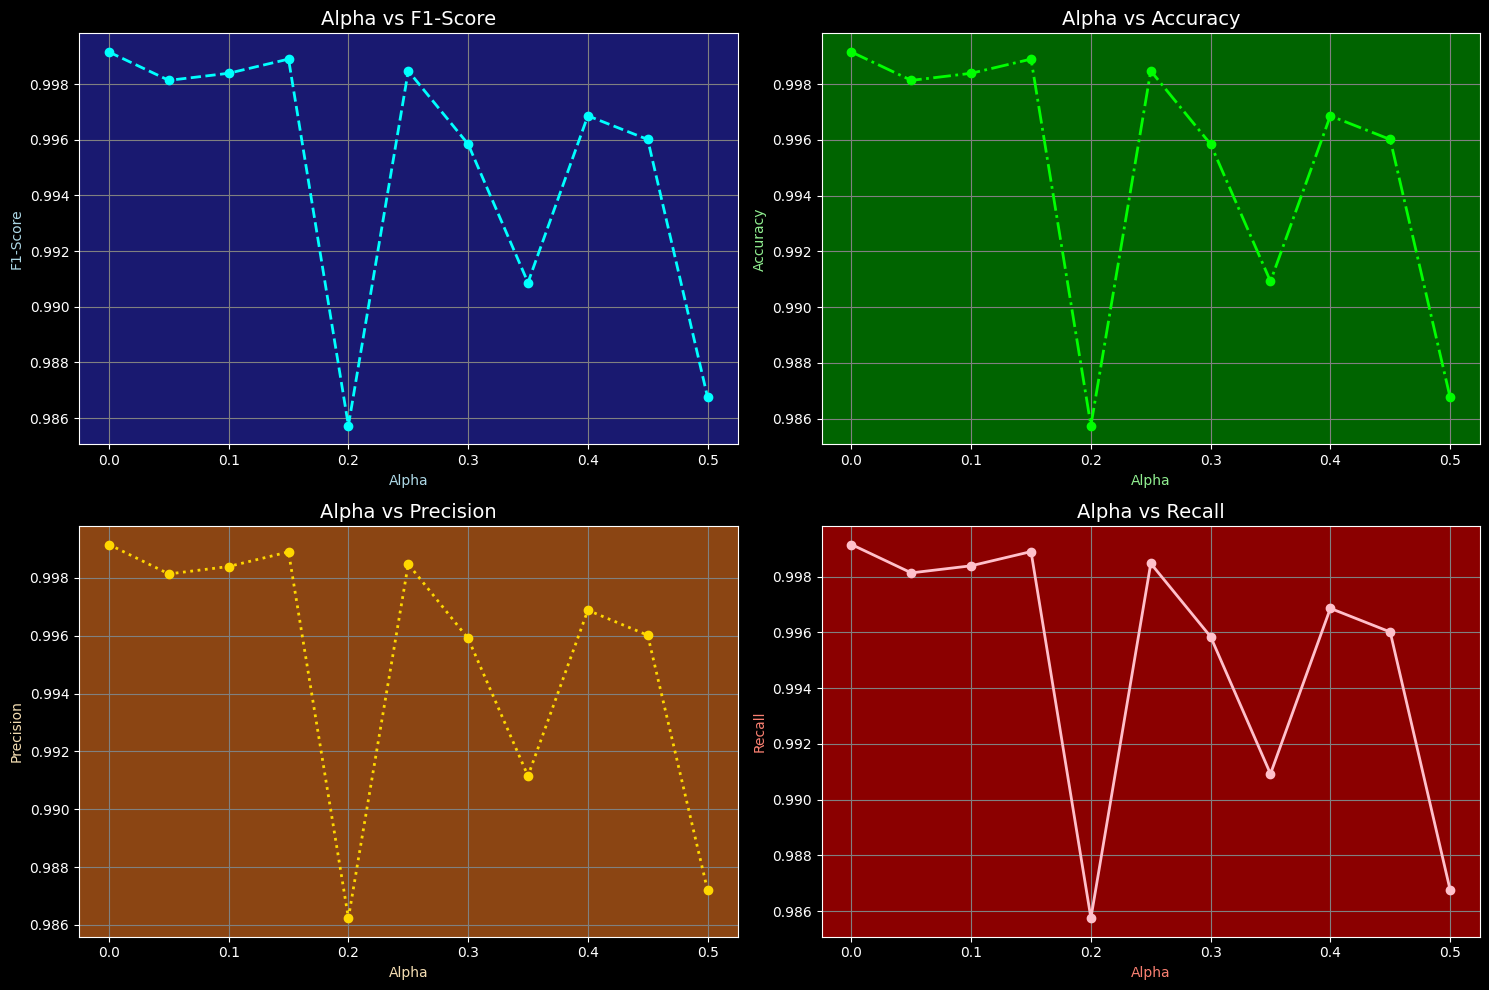

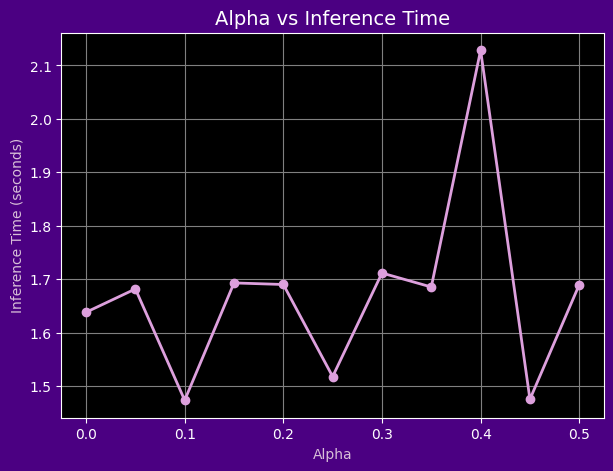

In [17]:
plt.style.use('dark_background')

plt.figure(figsize=(15, 10))

# Alpha vs F1-Score with a custom background color
plt.subplot(2, 2, 1, facecolor='midnightblue')
plt.plot(alpha_values, f1_scores, marker='o', color='cyan', linestyle='--', linewidth=2)
plt.title("Alpha vs F1-Score", fontsize=14, color='white')
plt.xlabel("Alpha", color='lightblue')
plt.ylabel("F1-Score", color='lightblue')
plt.grid(True, color='gray')

# Alpha vs Accuracy with a custom background color
plt.subplot(2, 2, 2, facecolor='darkgreen')
plt.plot(alpha_values, accuracies, marker='o', color='lime', linestyle='-.', linewidth=2)
plt.title("Alpha vs Accuracy", fontsize=14, color='white')
plt.xlabel("Alpha", color='lightgreen')
plt.ylabel("Accuracy", color='lightgreen')
plt.grid(True, color='gray')

# Alpha vs Precision with a custom background color
plt.subplot(2, 2, 3, facecolor='saddlebrown')
plt.plot(alpha_values, precisions, marker='o', color='gold', linestyle=':', linewidth=2)
plt.title("Alpha vs Precision", fontsize=14, color='white')
plt.xlabel("Alpha", color='wheat')
plt.ylabel("Precision", color='wheat')
plt.grid(True, color='gray')

# Alpha vs Recall with a custom background color
plt.subplot(2, 2, 4, facecolor='darkred')
plt.plot(alpha_values, recalls, marker='o', color='pink', linestyle='-', linewidth=2)
plt.title("Alpha vs Recall", fontsize=14, color='white')
plt.xlabel("Alpha", color='salmon')
plt.ylabel("Recall", color='salmon')
plt.grid(True, color='gray')

plt.tight_layout()
plt.show()

# Plot Inference Time vs. Alpha with custom background color separately
plt.figure(figsize=(7, 5), facecolor='indigo')
plt.plot(alpha_values, inference_times, marker='o', color='plum', linestyle='-', linewidth=2)
plt.title("Alpha vs Inference Time", fontsize=14, color='white')
plt.xlabel("Alpha", color='thistle')
plt.ylabel("Inference Time (seconds)", color='thistle')
plt.grid(True, color='gray')
plt.show()